<a id="obj"></a>
<h2>   
      <font color = blue >
            <span style='font-family:Georgia'>
            <b>Resume Analyzer</b>
            </span>   
        </font>    
</h2>

<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Installing Necessary Modules</b>
            </span>   
        </font>    
</h4>

In [ ]:
!pip install PyMuPDF PyPDF2 transformers nltk sklearn-crfsuite highlight-text

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

2023-12-10 05:48:34.245359: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 05:48:34.245415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 05:48:34.245458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 05:48:34.253190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 05:48:35.578382: W tensorflow/compiler/

<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Importing Necessary Libraries</b>
            </span>   
        </font>    
</h4>

In [ ]:
import tensorflow as tf
from transformers import pipeline, GPT2Tokenizer, TFAutoModelForCausalLM, TFGPT2LMHeadModel, GPT2LMHeadModel, T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration
import re

import fitz  # PyMuPDF
import PyPDF2

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')  # Download the VADER lexicon
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import sklearn_crfsuite

import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud
import plotly.express as px
from highlight_text import HighlightText, ax_text, fig_text

import numpy as np
import pandas as pd
import random

import ipywidgets as widgets
from IPython.display import display

from google.colab import files

import spacy

# Load pre-trained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

import warnings
# Filter out Matplotlib warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Defining Functions and other necessary lists</b>
            </span>   
        </font>    
</h4>

***Defining functions to read and preprocess the document***

In [ ]:
def read_pdf(file_path):
    text = ''
    with fitz.open(file_path) as pdf_document:
        for page_num in range(pdf_document.page_count):
            page = pdf_document[page_num]
            text += page.get_text()
    return text

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = ' '.join(text.split())

    # Remove punctuation
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove numbers
    tokens = [token for token in tokens if not token.isdigit()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back into a text
    text = ' '.join(tokens)

    return text


***Defining function to generate summary***

In [ ]:
def generate_summary(resume_text):
    # Tokenize input text
    inputs = tokenizer(resume_text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate summary
    summary_ids = model.generate(inputs["input_ids"], max_length=1024, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

***Defining functions to perform sentiment analysis and derive word clouds***

In [ ]:
# Function to perform sentiment analysis using NLTK
def analyze_sentiment_nltk(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)

    # Assign sentiment based on the compound score
    if sentiment_scores['compound'] >= 0.05:
        return 'POSITIVE'
    elif sentiment_scores['compound'] <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

# Function to identify tokens in each sentiment category
def identify_tokens_by_sentiment(text, sentiment):
    tokens = nltk.word_tokenize(text)
    sid = SentimentIntensityAnalyzer()

    # Filter tokens based on sentiment
    filtered_tokens = [token for token in tokens if sentiment == analyze_sentiment_nltk(token)]
    return filtered_tokens

# Function to visualize sentiments using Plotly Pie Chart
def visualize_sentiments_pie(sentiments_count):
    labels = list(sentiments_count.keys())
    counts = list(sentiments_count.values())
    total_count = sum(counts)

    percentages = [round(count / total_count * 100, 2) for count in counts]

    # Create a DataFrame for the pie chart
    df = pd.DataFrame({'Sentiment': labels, 'Percentage': percentages, 'Count': counts})

    # Define color mapping
    color_map = {'POSITIVE': 'green', 'NEGATIVE': 'red', 'NEUTRAL': 'blue'}

    fig = px.pie(df, names='Sentiment', values='Count', labels={'Sentiment': 'Sentiment', 'Count': 'Count'},
                 title='Sentiment Analysis (Radial Chart)',
                 hover_data=['Percentage'],  # Use a list for hover_data
                 hole=0.4,
                 color='Sentiment',
                 color_discrete_map=color_map)

    fig.update_traces(textinfo='percent+label', pull=[0.1, 0.1, 0.1])

    fig.show()

# Function to generate and display a word cloud with title
def generate_word_cloud_with_title(tokens, title, max_width=800, max_height=400):
    wordcloud = WordCloud(width=max_width, height=max_height, background_color='white').generate(' '.join(tokens))

    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


***Defining function to calculate the similarity score of resume with job description***

In [ ]:
# Function to calculate TF-IDF vectors and cosine similarity
def calculate_similarity(resume, job_description):
    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Fit and transform the resume and job description
    tfidf_matrix = vectorizer.fit_transform([resume, job_description])

    # Calculate cosine similarity
    similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

    return similarity_score

***Defining function to calculate the ATS Score***

In [ ]:
def calculate_general_ats_score(resume_text):
    # Placeholder weights for different criteria
    weights = {
        'word_choice': 0.2,
        'style_and_brevity': 0.15,
        'bullet_points': 0.1,
        'inconsistencies': 0.1,
        'length': 0.1,
        'filler_words': 0.1,
        'keywords_and_buzzwords': 0.25,
    }

    # Example criteria evaluation - you can customize this based on your needs
    word_choice_score = len(set(resume_text.lower().split()))
    style_and_brevity_score = 1.0  # Assume good style and brevity
    bullet_points_score = 0.9  # Assume well-structured bullet points
    inconsistencies_score = 0.8  # Assume few inconsistencies
    length_score = 0.7  # Assume moderate length
    filler_words_score = 0.8  # Assume few filler words
    keywords_and_buzzwords_score = 0.75  # Assume presence of relevant keywords and buzzwords

    # Calculate the overall ATS score
    ats_score = sum(weight * score for weight, score in zip(weights.values(), [word_choice_score, style_and_brevity_score, bullet_points_score, inconsistencies_score, length_score, filler_words_score, keywords_and_buzzwords_score]))

    # Ensure the overall ATS score is capped at 100%
    ats_score = min(ats_score, 100.0)

    return ats_score


***Defining function to find job roles matching the resume***

In [ ]:
def find_matching_job_roles(resume_text, job_roles, num_roles=5):
    # Combine the resume text and job roles
    all_texts = [resume_text] + job_roles

    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the texts into TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Calculate cosine similarity between the resume and job roles
    similarity_scores = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1:])[0]

    # Get indices of the top matching job roles
    top_indices = similarity_scores.argsort()[-num_roles:][::-1]

    # Get the corresponding job roles
    matching_job_roles = [job_roles[i] for i in top_indices]

    return matching_job_roles


job_roles = ["Software Developer","Data Scientist","Project Manager","Marketing Specialist","Financial Analyst","Human Resources Manager","Customer Service Representative","Sales Manager","Graphic Designer","Network Engineer","Medical Doctor","Civil Engineer","Content Writer","Social Media Manager","Accountant","Business Analyst","Product Manager","Mechanical Engineer","Pharmacist","Teacher","Research Scientist","Chef","Electrical Engineer","IT Consultant","Nurse","Architect","Event Planner","Legal Counsel","Logistics Coordinator","Financial Planner","Operations Manager","Quality Assurance Analyst","Web Developer","Art Director","Public Relations Specialist","Healthcare Administrator","Chemical Engineer","Systems Analyst","Data Analyst","UX/UI Designer","Digital Marketing Manager","Dentist","Mechanical Designer","Sales Representative","Executive Assistant","Fashion Designer","Network Administrator","Physiotherapist","Construction Manager","UX Researcher","Public Accountant","Market Research Analyst","Police Officer","Financial Controller","Environmental Scientist","Human Resources Coordinator","Customer Support Specialist","Supply Chain Manager","Statistician","Occupational Therapist","Physician Assistant","Project Coordinator","Software Engineer","Biomedical Engineer","Database Administrator","Corporate Trainer","Operations Analyst","Technical Writer","IT Manager","Brand Manager","Geologist","Speech Therapist","Industrial Engineer","Security Analyst","Product Designer","Mechatronics Engineer","Market Analyst","Insurance Agent","Research Assistant","Business Development Manager","Flight Attendant","Sports Coach","Radiologist","Risk Analyst","Medical Technologist","IT Support Specialist","Environmental Engineer","Interior Designer","Real Estate Agent","Biotechnologist","Bank Teller","Technical Support Engineer","Clinical Psychologist","Advertising Manager","Phlebotomist","Telecommunications Engineer","Cybersecurity Analyst","Political Analyst","Counselor","Network Security Engineer","Systems Engineer","Digital Content Creator","Pharmacologist","Market Researcher","Air Traffic Controller","Quality Control Inspector","Corporate Recruiter","Laboratory Technician","Legal Assistant","Health and Safety Officer","Financial Advisor","Public Health Specialist","Clinical Research Coordinator","Data Engineer","Customer Success Manager","IT Auditor","Forensic Scientist","Database Analyst","GIS Analyst","Technical Project Manager","SEO Specialist","Data Entry Clerk","Learning and Development Specialist","Clinical Nurse Specialist","Network Analyst","Risk Manager","Biomedical Scientist","Software Tester","Social Worker","Environmental Analyst","Training Coordinator","Quality Assurance Engineer","UX/UI Developer","Claims Adjuster","Hardware Engineer","Chemist","Market Planner","Biomedical Technician","Mobile App Developer","Occupational Health and Safety Specialist","Procurement Specialist","IT Security Specialist","Artificial Intelligence Engineer","Forensic Accountant","Research Biologist","Flight Engineer","Brand Ambassador","Medical Illustrator","Laboratory Manager","Compensation Analyst","Machine Learning Engineer","Health Educator","Technical Recruiter","Data Architect","Industrial Designer","IT Trainer","Financial Analyst","Physical Therapist","Quantitative Analyst","Digital Forensics Analyst","Geotechnical Engineer","Healthcare Consultant","Brand Strategist","Content Strategist","Community Manager","Tax Consultant","Virtual Reality Developer","Clinical Data Manager","Sustainability Consultant","Telecommunications Manager","Quality Assurance Tester","Hardware Designer","Research Analyst","Biostatistician","Financial Planner","Technology Consultant","Mobile Application Designer","Computer Systems Analyst","Cybersecurity Consultant","Robotics Engineer","Health Information Manager","Business Intelligence Analyst","Digital Illustrator","Technical Support Specialist","Financial Consultant","Emergency Medical Technician","IT Operations Manager","Research Scientist","GIS Specialist","Digital Marketing Specialist","Biomedical Researcher","Database Developer","Forensic Psychologist","Social Media Coordinator","Software Architect","User Interface Designer","Environmental Planner","IT Business Analyst","Corporate Communications Manager","Pharmaceutical Sales Representative","Technical Illustrator","Security Consultant","Network Manager","Quality Assurance Manager","IT Analyst","Clinical Research Associate","Research Engineer","Public Relations Manager","Information Security Analyst","Sustainability Analyst","Database Manager","Technical Project Coordinator","Business Systems Analyst","Software Implementation Specialist","Healthcare Administrator","Laboratory Assistant","Geographic Information Systems Analyst","Product Development Manager","Market Development Manager","Technical Account Manager","Clinical Laboratory Scientist","Research Coordinator","IT Security Analyst","Data Scientist","Technical Program Manager","Financial Analyst","Content Manager","Compensation Manager","Health and Safety Manager","Data Analyst","Network Administrator","Biomedical Engineer","Software Engineer","Pharmacist","Business Analyst","Graphic Designer","Research Scientist","Marketing Specialist","Environmental Scientist","Operations Manager","Data Entry Clerk","Medical Doctor","Human Resources Manager","Financial Planner","Teacher","Civil Engineer","Sales Manager","Product Manager","Social Media Manager","Mechanical Engineer","Content Writer","Accountant","Project Manager","IT Consultant","Nurse","Architect","Legal Counsel","Financial Analyst","Web Developer","Quality Assurance Analyst","Network Engineer","Art Director","Customer Service Representative","Financial Analyst"]

***Defining a corpus of questions***

In [ ]:
questions = [  "Explain the difference between stocks and bonds.",  "What is the purpose of a balance sheet?",  "Describe the concept of time value of money.",  "How do you calculate the present value of future cash flows?",  "What are the key financial statements, and what information do they provide?",  "Explain the CAPM (Capital Asset Pricing Model).",  "What is the difference between systematic and unsystematic risk?",  "How is the WACC (Weighted Average Cost of Capital) calculated?",  "Define working capital and its importance in financial management.",  "What is the role of a financial analyst?",  "Explain the process of budgeting and forecasting.",  "How do you assess a company's financial health?",  "What is EBITDA, and why is it used?",  "Describe the concept of leverage in finance.",  "What is the difference between equity and debt financing?",  "Explain the term 'liquidity ratio' and provide examples.",  "How do changes in interest rates affect bond prices?",  "What is the role of the SEC (Securities and Exchange Commission) in financial markets?",  "Define hedging and its significance in risk management.",  "How is ROI (Return on Investment) calculated?",  "What are the components of the DuPont analysis?",  "Explain the concept of financial derivatives.",  "How does inflation impact investment returns?",  "What is the difference between mergers and acquisitions?",  "Describe the purpose of a 10-K report.",  "What are the key factors in assessing a company's credit risk?",  "Explain the concept of economic value added (EVA).",  "What is the significance of the P/E ratio?",  "Describe the concept of working capital turnover ratio.",  "How do you calculate free cash flow?",  "What is the role of a Chief Financial Officer (CFO) in a company?",  "Explain the difference between accrual accounting and cash accounting.",  "How does the Federal Reserve influence interest rates?",  "What is the Black-Scholes model, and what is it used for?",  "Define the term 'alpha' in the context of investment performance.",  "How do you evaluate the risk-return tradeoff in investment decisions?",  "Explain the concept of dividend yield.",  "What is the impact of depreciation on financial statements?",  "Describe the concept of financial leverage.",  "How do you calculate the cost of equity?",  "What is the role of the World Bank in international finance?",  "Explain the purpose of a SWOT analysis in financial planning.",  "Define 'EBIT' and 'EBITDA' and explain their significance.",  "How do changes in exchange rates impact multinational corporations?",  "What is the significance of the quick ratio?",  "Describe the concept of cash conversion cycle.",  "How do you analyze a company's cash flow statement?",  "What is the efficient market hypothesis?",  "Explain the term 'yield curve' and its implications for the economy.",  "How does a company's dividend policy impact its stock price?",  "Define the concept of financial modeling.",  "What is the role of the Financial Accounting Standards Board (FASB)?",  "How do you assess the creditworthiness of a potential borrower?",  "Explain the concept of intrinsic value in stock valuation.",  "What is the difference between forward and futures contracts?",  "Describe the concept of hurdle rate in capital budgeting.",  "How is the cost of debt calculated?",  "What is the role of the International Monetary Fund (IMF)?",  "Explain the concept of market risk.",  "How do you calculate the net present value (NPV) of an investment?",  "Define the term 'diversification' and its importance in investment portfolios.",  "What is the role of a financial planner?",  "Explain the concept of systematic and unsystematic risk.",  "How do you calculate the quick ratio?",  "What is the significance of the Sharpe ratio?",  "Describe the impact of inflation on financial planning.",  "How does the Federal Open Market Committee (FOMC) influence monetary policy?",  "What is the role of financial institutions in the economy?",  "Explain the concept of cost of capital and its components.",  "How do you assess the financial performance of a publicly traded company?",  "Define the term 'arbitrage' and provide an example.",  "What is the role of a credit rating agency in financial markets?",  "Explain the concept of financial statement analysis.",  "How does the business cycle impact financial markets?",  "What is the purpose of a cash flow statement?",  "Define the term 'beta' in the context of risk assessment.",  "How do you calculate the economic order quantity (EOQ) in inventory management?",  "Explain the concept of sustainable growth rate.",  "What is the significance of the Federal Funds Rate in monetary policy?",  "Describe the process of financial planning in a corporate setting.",  "How do changes in interest rates impact bond yields?",  "What is the role of risk management in financial decision-making?",  "Explain the concept of hurdle rate in project finance.",  "Define the term 'volatility' in financial markets.",  "How do you analyze financial ratios to assess a company's performance?",  "Explain the concept of demand forecasting and its importance in operations management.",  "How do you optimize inventory levels to balance between overstock and stockouts?",  "Describe the key components of a supply chain and their interdependencies.",  "What is the role of a Kanban system in lean manufacturing?",  "How do you ensure quality control in the production process?",  "Explain the difference between MRP (Material Requirements Planning) and JIT (Just-in-Time) inventory systems.",  "What are the key performance indicators (KPIs) you would use to measure operational efficiency?",  "How do you assess and mitigate risks in the supply chain?",  "Explain the concept of Six Sigma and its application in process improvement.",  "What is the significance of lead time in supply chain management?",  "How do you approach capacity planning in a manufacturing environment?",  "Describe your experience with implementing process improvements using continuous improvement methodologies.",  "What is the role of technology, such as ERP systems, in operations management?",  "How do you prioritize tasks when faced with multiple competing demands on resources?",  "Explain the principles of Total Quality Management (TQM).",  "How do you manage relationships with suppliers to ensure a reliable and cost-effective supply chain?",  "Describe a situation where you successfully reduced operational costs in a previous role.",  "What strategies do you employ to optimize production scheduling?",  "How do you handle unexpected disruptions in the supply chain?",  "Explain the concept of value stream mapping and its use in process improvement.",  "What role does data analytics play in optimizing operational processes?",  "How do you ensure compliance with relevant industry regulations in your operations?",  "Describe your experience with implementing and managing lean manufacturing principles.",  "What is the significance of the EOQ (Economic Order Quantity) model in inventory management?",  "How do you manage and resolve conflicts within a cross-functional team?",  "Explain the importance of sustainability in operations management.",  "What steps do you take to ensure a smooth and efficient order fulfillment process?",  "Describe a situation where you had to make a critical decision to ensure operational continuity.",  "How do you foster a culture of continuous improvement within an operations team?",  "Explain the concept of process mapping and its role in identifying inefficiencies.",  "What is the role of benchmarking in evaluating and improving operational performance?",  "How do you assess and optimize the layout of a manufacturing facility for improved efficiency?",  "Describe your experience with demand planning and forecasting techniques.",  "What measures do you take to ensure workplace safety in an operations setting?",  "Explain the concept of Just-in-Time production and its benefits.",  "How do you balance cost-effectiveness and sustainability in supply chain decisions?",  "Describe a successful implementation of a new technology or software system in operations.",  "What is the importance of cross-training employees in an operations team?",  "How do you prioritize customer satisfaction in your operations strategy?",  "Explain the concept of a bottleneck in operations and how you would address it.",  "What is the role of Key Performance Indicators (KPIs) in monitoring and improving operations?",  "How do you ensure accurate and timely reporting of operational metrics?",  "Describe your experience with implementing and managing safety protocols in a manufacturing environment.",  "What steps do you take to ensure a smooth transition when implementing changes in operations?",  "Explain the concept of the Bullwhip Effect and its impact on the supply chain.",  "How do you incorporate sustainability practices in the procurement process?",  "Describe a situation where you had to resolve a conflict between different departments in operations.",  "What role does technology play in optimizing warehouse management processes?",  "How do you approach the optimization of transportation and logistics in the supply chain?",  "Explain the concept of Pareto analysis and its application in operations management.",  "What is the role of a Master Production Schedule (MPS) in manufacturing planning?",  "How do you stay updated on industry trends and best practices in operations management?",  "Describe your experience with implementing and managing quality management systems.",  "What measures do you take to ensure the security of sensitive operational data?",  "Explain the concept of cycle time and its relevance in process efficiency.",  "How do you assess and improve the performance of suppliers in the supply chain?",  "Describe a situation where you had to implement changes to meet regulatory compliance.",  "What is the role of a Bill of Materials (BOM) in production planning and control?",  "How do you balance the need for cost reduction with the requirement for high-quality products?",  "Explain the concept of capacity utilization and its impact on operational efficiency.",  "What strategies do you employ to reduce lead times in the production process?",  "How do you ensure the security and integrity of inventory data in an ERP system?",  "Describe a situation where you had to manage a crisis in the operations of a business.",  "What is the importance of cross-functional collaboration in operations management?",  "How do you assess the effectiveness of a vendor management program?",  "Explain the concept of Kaizen and its role in continuous improvement.",  "What measures do you take to ensure that operations are aligned with overall business goals?",  "Describe your experience with implementing quality control measures in a manufacturing setting.",  "How do you balance the need for automation with the potential impact on employment?",  "What role does employee training and development play in optimizing operations?",  "Explain the concept of a service level agreement (SLA) in the context of supply chain management.",  "How do you ensure the efficient allocation of resources in a production environment?",  "Describe your approach to managing and optimizing the reverse logistics process.",  "What steps do you take to ensure the traceability of products throughout the supply chain?",  "Explain the concept of earned value management and its application in project tracking.",  "How do you assess and improve the energy efficiency of operations in a manufacturing facility?",  "Describe a situation where you had to implement cost-saving measures without compromising quality.",  "What is the role of a Work Breakdown Structure (WBS) in project planning and control?",  "How do you approach the implementation of sustainability initiatives in operations?",  "Explain the concept of cross-docking and its benefits in logistics management.",  "What measures do you take to ensure the security of intellectual property in operations?",  "Describe your experience with implementing and managing change management processes.",  "How do you prioritize projects within the operations portfolio based on strategic goals?",  "What role does data security and privacy play in the selection of technology solutions for operations?",  "Explain the concept of vendor scorecards and their use in supplier performance evaluation.",  "How do you ensure compliance with international standards in the operations of a global supply chain?",  "Describe a situation where you had to optimize the use of technology in warehouse management.",  "What steps do you take to ensure the ethical sourcing of materials in the supply chain?",  "Explain the concept of a Critical Path Method (CPM) and its application in project scheduling.",  "How do you ensure the scalability of operational processes to accommodate business growth?",  "What measures do you take to foster a culture of safety and well-being in the workplace?",  "Describe your approach to managing and optimizing the last-mile delivery process.",  "What role does performance measurement play in the evaluation of operations initiatives?",    "How do you ensure compliance with HR laws and regulations?",    "Explain the importance of confidentiality in HR.",    "What HRIS (Human Resource Information System) have you used?",    "How do you handle employee relations issues?",    "Describe your experience with talent acquisition and recruitment strategies.",    "What is your approach to employee onboarding?",    "How do you conduct performance evaluations?",    "Explain the concept of diversity and inclusion in the workplace.",    "How do you handle conflicts between employees?",    "Describe your experience with benefits administration.",    "What methods do you use for employee training and development?",    "How do you stay updated on changes in HR laws and best practices?",    "Explain the role of HR in organizational culture.",    "Describe your approach to handling employee grievances.",    "How do you manage employee retention?",    "What metrics do you track to measure HR effectiveness?",    "Explain the significance of a company's employer brand.",    "How do you conduct exit interviews?",    "Describe your experience in creating HR policies and procedures.",    "What strategies do you use for workforce planning?",    "How do you address issues related to workplace harassment?",    "Explain the role of HR in talent management.",    "What is your experience with HR analytics?",    "How do you handle requests for flexible work arrangements?",    "Describe your approach to leadership development programs.",    "What is your understanding of employee engagement?",    "How do you ensure fair compensation and benefits across the organization?",    "Explain the concept of succession planning.",    "How do you handle layoffs or downsizing?",    "Describe your approach to promoting a positive work culture.",    "What methods do you use for employee recognition and rewards?",    "How do you handle sensitive information, such as employee data?",    "Explain the importance of diversity in recruitment.",    "Describe your experience with HR budgeting.",    "How do you handle workplace safety and health concerns?",    "What role does HR play in organizational change management?",    "Explain your approach to promoting work-life balance.",    "How do you address issues related to workplace ethics?",    "Describe your experience with HR compliance audits.",    "What strategies do you use for employee career development?",    "How do you address issues related to workplace diversity?",    "Explain the concept of employee wellness programs.",    "Describe your approach to managing employee benefits enrollment.",    "What methods do you use for conflict resolution?",    "How do you handle employee relations in a remote work environment?",    "Explain the significance of HR in mergers and acquisitions.",    "Describe your approach to conducting HR investigations.",    "What is your experience with employee performance improvement plans?",    "How do you ensure fair and unbiased recruitment processes?",    "Explain the role of HR in fostering a positive employer-employee relationship.",    "Describe your approach to employee feedback and surveys.",    "What methods do you use for workforce diversity and inclusion training?",    "How do you handle requests for workplace accommodations?",    "Explain the concept of HR's role in talent retention.",    "Describe your approach to HR metrics and key performance indicators.",    "What strategies do you use for employee motivation?",    "How do you handle employee complaints about management?",    "Explain your approach to HR technology implementation.",    "Describe your experience with employee benefits negotiations.",    "What is your understanding of HR's role in employee advocacy?",    "How do you address issues related to workplace bullying?",    "What methods do you use for HR process improvement?",    "How do you handle HR-related data security and privacy?",    "Explain the importance of HR in corporate social responsibility.",    "Describe your approach to managing HR during a crisis or emergency.",    "What is your experience with global or international HR management?",    "How do you handle HR-related communications with employees?",    "Explain your approach to managing HR projects and initiatives.",    "Describe your experience with HR-related software and tools.",    "What methods do you use for employee conflict mediation?",    "How do you stay informed about industry trends in HR?",    "Explain the significance of HR in employee satisfaction and morale.",    "Describe your approach to managing HR during periods of organizational change.",    "What is your understanding of HR's role in talent acquisition strategy?",    "How do you address issues related to workplace discrimination?",    "What strategies do you use for HR workforce planning?",    "How do you handle HR-related training and development programs?",    "Explain the concept of HR's role in organizational performance management.",    "Describe your experience with HR-related software implementation projects.",    "What is your approach to HR-related employee communications and engagement?",    "How do you ensure diversity and inclusion in recruitment and hiring processes?",    "Explain the importance of HR in fostering a positive workplace culture.",    "Describe your approach to managing HR during periods of rapid organizational growth.",    "What methods do you use for HR-related employee performance assessments?",    "How do you handle HR-related communications during a crisis or emergency?",    "Explain your approach to HR's role in fostering innovation within the organization.",    "Describe your experience with HR-related employee benefits design and administration.",    "What is your understanding of HR's role in organizational leadership development?",    "How do you address issues related to workplace conflict resolution?",    "What strategies do you use for HR-related workforce management and optimization?",    "How do you handle HR-related communication with employees during remote work arrangements?"]
questions2=["Explain the difference between supervised and unsupervised learning.", "How does regularization prevent overfitting in machine learning models?", "What is the purpose of cross-validation in model training?", "Describe the curse of dimensionality and its impact on machine learning algorithms.", "What is the significance of the p-value in statistics?", "Explain the difference between correlation and causation.", "What is the purpose of A/B testing?", "How does a decision tree work, and what are its advantages and disadvantages?", "Explain the terms precision and recall in the context of classification models.", "What is clustering, and provide examples of clustering algorithms.", "What is the ROC curve, and how is it used to evaluate the performance of a classification model?", "What is feature engineering, and why is it important in machine learning?", "Explain the concept of outlier detection and methods to handle outliers.", "What is logistic regression, and how does it differ from linear regression?", "Describe the differences between bagging and boosting in ensemble learning.", "What is the purpose of the K-nearest neighbors (KNN) algorithm?", "How does gradient descent work in the context of optimizing machine learning models?", "Explain the concept of time-series analysis and its applications.", "What is the difference between a data lake and a data warehouse?", "How does the MapReduce paradigm work in the context of big data processing?", "Describe the process of natural language processing (NLP) and its applications.", "What is the difference between overfitting and underfitting in machine learning?", "Explain the concept of bias-variance tradeoff in model training.", "What are hyperparameters, and how do they differ from model parameters?", "Describe the importance of feature scaling in machine learning.", "How does the K-means clustering algorithm work?", "Explain the purpose of regularization techniques in linear regression.", "What is the difference between a random forest and a decision tree?", "How does the Naive Bayes algorithm work, and where is it commonly used?", "What is the role of activation functions in neural networks?", "Explain the concept of cross-entropy loss in classification models.", "What is the purpose of the term TF-IDF in natural language processing?", "How does dimensionality reduction contribute to machine learning models?", "What are the assumptions of linear regression?", "Describe the concept of one-hot encoding in feature representation.", "What is the difference between classification and regression?", "Explain the concept of collaborative filtering in recommendation systems.", "How does the Apriori algorithm work in association rule mining?", "What is the purpose of a confusion matrix in machine learning?", "Describe the concept of batch normalization in neural networks.", "How does the Support Vector Machine (SVM) algorithm work?", "Explain the concept of imbalanced datasets and methods to address them.", "What is the role of backpropagation in training neural networks?", "Describe the concept of PCA (Principal Component Analysis).", "How does the bias term affect the performance of a linear regression model?", "What is the difference between a box plot and a histogram?", "Explain the concept of bootstrapping in statistics.", "How does the expectation-maximization (EM) algorithm work?", "What is the purpose of the F1 score in classification evaluation?", "Describe the differences between L1 and L2 regularization.", "How does the LDA (Linear Discriminant Analysis) algorithm work?", "Explain the concept of feature importance in ensemble learning.", "What is the purpose of the chi-squared test in statistics?", "Describe the differences between batch processing and stream processing in data engineering.", "How does the concept of entropy apply to decision trees?", "What is the role of dropout in neural network regularization?", "Explain the concept of A/B/C testing and when it is appropriate to use each.", "How does the expectation-maximization (EM) algorithm work in clustering?", "What is the purpose of the learning rate in gradient descent optimization?", "Describe the concept of word embeddings in natural language processing.", "How does the R-squared metric measure the goodness of fit in regression models?", "Explain the concept of ensemble learning and provide examples.", "What is the difference between a left join and an inner join in SQL?", "Describe the purpose of a kernel in the context of Support Vector Machines.", "How does the Apriori algorithm contribute to market basket analysis?", "What is the purpose of the term dropout in neural network architectures?", "Explain the concept of autocorrelation in time series analysis.", "How does the concept of entropy relate to information gain in decision trees?", "Describe the purpose of LSTMs (Long Short-Term Memory) in recurrent neural networks.", "What is the role of batch normalization in training deep neural networks?", "Explain the concept of the bias-variance tradeoff in model evaluation.", "How does the Kullback-Leibler (KL) divergence measure the difference between probability distributions?", "What is the purpose of the term embedding in natural language processing?", "Describe the differences between batch gradient descent and stochastic gradient descent.", "How does the concept of precision at k differ from standard precision in classification models?", "Explain the purpose of dropout layers in convolutional neural networks.", "What is the difference between a left join and a right join in SQL?", "How does the term bagging contribute to the performance of ensemble learning models?", "Describe the differences between L1 and L2 loss functions in machine learning.", "What is the role of activation functions in the hidden layers of neural networks?", "Explain the concept of transfer learning in deep learning models.", "How does the concept of inertia apply to the K-means clustering algorithm?", "What is the purpose of a ROC-AUC curve in evaluating binary classification models?", "Describe the differences between precision and recall in the context of imbalanced datasets.", "How does the concept of cosine similarity contribute to text similarity calculations?", "What is the role of the term dropout in convolutional neural network architectures?", "Explain the concept of bag-of-words in natural language processing.", "How does the concept of cross-entropy loss contribute to the training of neural networks?", "What is the difference between a shallow neural network and a deep neural network?", "Describe the differences between online learning and batch learning in machine learning.", "What is the purpose of the term hashing in feature representation?", "How does the concept of mean squared error contribute to the evaluation of regression models?", "Explain the purpose of the term word2vec in natural language processing.", "What is the difference between a point estimate and an interval estimate in statistics?","Explain the difference between process and thread in Python.","How does garbage collection work in Python?","Describe the Global Interpreter Lock (GIL) in Python and its impact on multi-threading.","What is the purpose of the 'yield' keyword in Python?","Explain the concept of decorators in Python.","How does Python's memory management work?","What is the difference between 'deep copy' and 'shallow copy' in Python?","Explain the use of the 'map()' function in Python.","What is the difference between a list and a tuple in Python?","Discuss the Global Variables and Local Variables in Python.","How does exception handling work in Python?","Explain the purpose of the '__init__' method in Python classes.","Discuss the differences between Python 2 and Python 3.","How does Python support functional programming?","What is the purpose of the 'self' parameter in Python class methods?","Explain the use of the 'lambda' function in Python.","What are decorators used for in Python?","How does the Python interpreter locate modules?","Explain the 'with' statement in Python.","What is the purpose of the 'zip()' function in Python?","Discuss the use of the 'assert' statement in Python.","How does Python support multi-threading?","Explain the concept of list comprehensions in Python.","What is the purpose of the '__str__' method in Python classes?","Discuss the differences between a set and a frozenset in Python.","How does Python handle default arguments in function calls?","Explain the concept of metaclasses in Python.","What is the purpose of the 'pickle' module in Python?","Discuss the use of the 'enumerate()' function in Python.","How do you perform file I/O operations in Python?","What is the purpose of the 'try' 'except' 'else' and 'finally' blocks in Python?","Explain the concept of a generator in Python.","Discuss the differences between 'os' and 'sys' modules in Python.","How does Python support multi-processing?","What is the purpose of the 'super()' function in Python?","Explain the concept of a virtual environment in Python.","Discuss the use of the 'filter()' function in Python.","What is the purpose of the 'staticmethod' in Python?","How do you handle circular references in Python?","Explain the purpose of the '__slots__' attribute in Python classes.","What is the purpose of the 'asyncio' module in Python?","Discuss the differences between 'deep learning' and 'machine learning'.","How does Python implement regular expressions?","Explain the concept of 'thread safety' in Python.","What is the purpose of the 'pip' tool in Python?","How does Python manage memory leaks?","Discuss the purpose of the 'sys.argv' variable in Python.","Explain the use of the 're.compile()' function in Python.","How does Python implement the 'heapq' module?","What is the purpose of the 'logging' module in Python?","Discuss the differences between 'WebSockets' and 'HTTP'.","How does Python support functional programming?","What is the purpose of the 'async' and 'await' keywords in Python?","Explain the use of the 'mmap' module in Python.","How does Python implement the 'JSON' module?","Discuss the purpose of the 'os.path' module in Python.","What is the purpose of the 'hashlib' module in Python?","How does Python implement the 'collections' module?","Explain the concept of 'pickle' serialization in Python.","What is the purpose of the 'requests' library in Python?","Discuss the differences between 'REST' and 'SOAP' APIs.","How does Python implement the 'itertools' module?","Explain the concept of 'duck typing' in Python.","What is the purpose of the 'contextlib' module in Python?","How does Python implement 'memoization'?","Discuss the use of the 'PyQt' library in Python.","What is the purpose of the 'glob' module in Python?","How does Python implement 'closures'?","Explain the concept of 'pipenv' in Python.","What is the purpose of the 'venv' module in Python?","Discuss the differences between 'UDP' and 'TCP' protocols.","How does Python implement 'serialization'?","Explain the use of the 'math' module in Python.","What is the purpose of the 'async/await' pattern in Python?","How does Python implement 'decorators' internally?","Discuss the purpose of the 'xml.etree.ElementTree' module in Python.","What is the purpose of the 'unittest' module in Python?","How does Python implement 'memoization'?","Explain the concept of 'dependency injection' in Python.","What is the purpose of the 'typing' module in Python?",    "Explain the difference between SEO and SEM.",    "How do you measure the success of a marketing campaign?",    "Can you describe the AIDA model and its relevance in marketing?",    "What is the importance of target audience segmentation?",    "How would you approach building a marketing strategy for a new product launch?",    "Explain the concept of customer journey mapping.",    "What role does content marketing play in a comprehensive marketing strategy?",    "How do you stay updated on the latest marketing trends and tools?",    "Describe the significance of the marketing funnel.",    "What is the difference between B2B and B2C marketing?",    "How would you use social media in a marketing campaign?",    "What is the purpose of A/B testing in marketing?",    "How do you determine a marketing budget for a campaign?",    "Can you provide examples of successful guerrilla marketing campaigns?",    "What is the impact of mobile optimization on digital marketing?",    "Explain the concept of brand positioning.",    "How do you approach influencer marketing, and what are its advantages?",    "Describe the role of data analytics in marketing decision-making.",    "What is the importance of call-to-action (CTA) in marketing materials?",    "How do you handle negative feedback or criticism in social media marketing?",    "Explain the concept of native advertising.",    "How do you assess the effectiveness of email marketing campaigns?",    "What is the significance of customer lifetime value (CLV) in marketing?",    "How do you differentiate between leads and prospects?",    "Describe the role of market research in shaping marketing strategies.",    "What are the key components of a marketing plan?",    "How do you approach competitor analysis in marketing?",    "Explain the concept of customer retention in marketing.",    "What is the importance of storytelling in marketing?",    "How would you utilize data-driven marketing in a campaign?",    "Describe the principles of ethical marketing.",    "What is the difference between inbound and outbound marketing?",    "How do you incorporate video content into a marketing strategy?",    "Explain the concept of customer persona in marketing.",    "How would you approach localization in international marketing?",    "Describe the concept of brand equity.",    "What role does public relations play in a marketing strategy?",    "How do you align marketing efforts with overall business goals?",    "Explain the concept of customer engagement in digital marketing.",    "What is the significance of a SWOT analysis in marketing?",    "How do you measure the ROI of a marketing campaign?",    "Can you provide examples of successful integrated marketing campaigns?",    "What is the impact of artificial intelligence on marketing?",    "How do you optimize landing pages for better conversion rates?",    "Explain the concept of the marketing mix (4Ps).",    "How would you approach marketing to different generations (e.g., Millennials, Gen Z)?",    "Describe the role of customer testimonials in marketing.",    "What is the significance of a marketing dashboard?",    "How do you address issues of data privacy in marketing?",    "Explain the concept of brand positioning.",    "How do you utilize customer feedback in refining marketing strategies?",    "What is the role of storytelling in creating a brand identity?",    "How do you choose the right marketing channels for a specific campaign?",    "Describe the impact of user-generated content on marketing.",    "What are the key metrics to track in social media marketing?",    "How do you integrate marketing automation into a campaign?",    "Explain the concept of earned, owned, and paid media in marketing.",    "How do you approach cross-channel marketing?",    "What is the importance of customer segmentation in personalized marketing?",    "Describe the role of emotional appeal in advertising.",    "How would you address challenges in measuring the success of a marketing campaign?",    "Explain the concept of lead nurturing in marketing.",    "What is the significance of mobile-first design in digital marketing?",    "How do you adapt marketing strategies to cultural differences?",    "Describe the impact of voice search on SEO and marketing.",    "What role does community building play in digital marketing?",    "How do you use data to create buyer personas?",    "Explain the concept of omnichannel marketing.",    "How do you approach marketing analytics for attribution modeling?",    "What is the role of customer feedback loops in refining marketing strategies?",    "Describe the impact of social listening on marketing decision-making.",    "How do you align marketing initiatives with customer expectations?",    "What is the significance of customer touchpoints in a buyer's journey?",    "Explain the concept of programmatic advertising in digital marketing.",    "How do you ensure brand consistency across different marketing channels?",    "What role does gamification play in marketing engagement?",    "Describe the impact of augmented reality (AR) on marketing experiences.",    "How do you approach ethical considerations in influencer marketing?",    "What is the role of chatbots in enhancing customer interactions in marketing?",    "Explain the concept of customer-centric marketing.",    "How do you leverage social proof in marketing?",    "What is the impact of micro-moments on consumer behavior and marketing strategies?",    "Describe the role of sentiment analysis in social media marketing.",    "How do you approach internationalization in digital marketing?",    "What is the significance of visual content in social media marketing?",    "Explain the concept of growth hacking in digital marketing.",    "How do you address challenges related to ad fraud in online advertising?",    "What role does influencer marketing play in reaching niche audiences?",    "Describe the impact of mobile advertising on consumer behavior."]
questions3=["How do you approach analyzing and solving complex business problems?","Can you provide an example of a successful strategy you developed for a client or company?","What frameworks or methodologies do you use in your strategic analysis?","How do you stay updated on industry trends and market dynamics?","Explain the difference between cost leadership and differentiation strategies.","What role does data analytics play in your strategic decision-making process?","How do you assess a company's competitive landscape?","Describe a situation where you had to manage conflicting stakeholder interests.","How do you prioritize and manage multiple strategic initiatives simultaneously?","What steps would you take to assess the feasibility of implementing a new business strategy?","Can you discuss a situation where a strategic initiative you recommended didn't go as planned? How did you handle it?","What is the significance of SWOT analysis in strategic planning?","Explain the concept of the value chain and its importance in strategy formulation.","How do you conduct a risk analysis for a proposed business strategy?","Discuss the role of innovation in strategic management.","How do you align IT strategy with overall business strategy?","What factors do you consider when evaluating potential mergers and acquisitions?","Can you provide an example of a successful organizational change you were involved in?","How do you assess the impact of geopolitical factors on business strategy?","Explain the concept of blue ocean strategy. Can you provide an example?","How do you approach crafting a business model for a new product or service?","Discuss the importance of a company's culture in the success of its strategy.","How do you communicate complex strategic concepts to non-technical stakeholders?","Explain the concept of scenario planning and its relevance in strategic decision-making.","What role does customer feedback play in shaping your strategic recommendations?","How do you incorporate sustainability considerations into strategic planning?","Discuss the balance between short-term gains and long-term sustainability in strategic decision-making.","What is your approach to setting and measuring key performance indicators (KPIs) for strategic initiatives?","Can you discuss a situation where you had to navigate regulatory challenges in a strategic project?","How do you assess the digital maturity of a company and its impact on strategic planning?","What is your process for conducting a competitive analysis for a new market entry?","How do you assess the potential risks and benefits of leveraging emerging technologies in business strategy?","Explain the concept of a strategic alliance. Can you provide an example?","What role does organizational structure play in supporting or hindering strategic initiatives?","How do you ensure that a strategic plan is effectively communicated and executed throughout the organization?","Describe your approach to balancing the needs of different business units in a large organization.","How do you handle resistance to change when implementing a new strategic initiative?","What is your perspective on the balance between standardization and customization in global business strategy?","How do you assess the financial viability of a proposed strategic initiative?","Discuss the role of leadership in driving successful strategy execution.","How do you evaluate the impact of macroeconomic factors on business strategy?","What is your approach to creating a culture of continuous improvement within an organization?","Explain the concept of competitive advantage and how it can be sustained over time.","How do you assess the potential impact of disruptive technologies on a company's business model?","Discuss the importance of customer segmentation in formulating marketing and business strategies.","What steps would you take to turn around a business facing financial challenges?","How do you balance the need for innovation with the need for operational efficiency in strategy development?","Explain the concept of a core competency and its role in shaping a company's strategy.","How do you approach strategic decision-making in a rapidly changing industry?","What is your experience with crisis management and its integration into strategic planning?","How do you assess the social and cultural factors that may affect a company's strategy?","Can you discuss a situation where you had to reevaluate and adjust a strategic plan mid-implementation?","What is your perspective on the role of artificial intelligence in shaping business strategy?","How do you foster a culture of strategic thinking and decision-making within an organization?","Explain the concept of a learning organization and its connection to strategic success.","What steps would you take to ensure that a strategic plan is aligned with the company's mission and values?","How do you assess the impact of demographic trends on market opportunities and risks?","Discuss the role of benchmarking in evaluating the performance of a company's strategic initiatives.","How do you incorporate customer journey mapping into strategic planning?","Explain the concept of a 'first-mover advantage' in the context of strategic decision-making.","What is your approach to assessing the financial health of a potential strategic partner?","How do you align marketing strategy with overall business strategy?","Discuss the role of corporate social responsibility (CSR) in strategic decision-making.","How do you evaluate the scalability of a business model in the context of strategic planning?","Explain the concept of a 'burning platform' and its role in driving strategic change.","How do you assess the potential impact of geopolitical events on supply chain strategy?","What is your approach to managing conflicts of interest among key stakeholders in strategic projects?","Discuss the role of big data in shaping business strategy.","How do you ensure that a strategic plan takes into account the diversity of global markets?","What steps would you take to assess the cultural fit between organizations in a merger or acquisition?","How do you incorporate environmental sustainability into the formulation of business strategies?","Explain the concept of strategic agility and its importance in a dynamic business environment.","What role does customer experience play in shaping your strategic recommendations?","How do you assess the potential impact of changing consumer behaviors on business strategy?","Discuss the importance of a well-defined target market in strategic marketing.","How do you approach strategic decision-making in a highly regulated industry?","What is your perspective on the role of predictive analytics in strategic planning?","How do you prioritize strategic initiatives in a resource-constrained environment?","Explain the concept of a 'balanced scorecard' and its relevance in measuring strategic performance.","How do you assess the potential impact of cultural differences on global business strategy?","Discuss the role of organizational agility in responding to changes in the competitive landscape.","How do you evaluate the effectiveness of a company's digital marketing strategy?","What steps would you take to ensure that a strategic plan is aligned with the organization's risk tolerance?","How do you assess the potential impact of trade policies on a company's international business strategy?","Explain the concept of 'strategic fit' and its importance in mergers and acquisitions.","What is your approach to managing cross-functional teams in the implementation of strategic projects?","How do you assess the potential impact of changing technology trends on a company's IT strategy?","Discuss the role of market segmentation in developing targeted marketing strategies.","How do you ensure that a strategic plan is adaptable to unforeseen external disruptions?","Explain the concept of a 'strategic gap' and how it can be addressed in planning.","How do you assess the potential impact of cybersecurity threats on a company's overall strategy?","What steps would you take to ensure that a strategic plan aligns with the organization's ethical standards?","How do you approach strategic decision-making in a highly competitive market?","Discuss the importance of a well-defined brand strategy in overall business strategy.","How do you evaluate the effectiveness of a company's crisis communication strategy?","Explain the concept of a 'strategic pivot' and its role in responding to market changes.",  "Explain the concept of elasticity in economics.",  "How does quantitative easing impact inflation?",  "Describe the Phillips curve and its implications for monetary policy.",  "What is the difference between microeconomics and macroeconomics?",  "Explain the concept of opportunity cost.",  "How does fiscal policy influence the economy?",  "Define Gross Domestic Product (GDP) and its components.",  "What are the factors that affect international trade?",  "Explain the law of diminishing marginal utility.",  "Discuss the role of central banks in controlling monetary policy.",  "What is the Laffer curve, and how does it relate to taxation?",  "Describe the impact of inflation on purchasing power.",  "Explain the concept of game theory in economics.",  "Discuss the functions of money in an economy.",  "What is the difference between monetary policy and fiscal policy?",  "Explain the concept of comparative advantage in international trade.",  "Discuss the economic indicators used to assess a country's economic health.",  "What role does the government play in a market economy?",  "Explain the concept of externalities in economic decision-making.",  "How do changes in interest rates affect investment and consumption?",  "Discuss the challenges and benefits of globalization in the context of economics.",  "What is the difference between nominal and real GDP?",  "Explain the concept of supply and demand.",  "Discuss the impact of government deficits on the economy.",  "How does the labor market influence economic outcomes?",  "Describe the concept of a production possibility frontier (PPF).",  "Explain the role of the World Trade Organization (WTO) in international trade.",  "Discuss the economic implications of technological advancements.",  "What is the significance of the Consumer Price Index (CPI) in measuring inflation?",  "Explain the concept of fiscal sustainability.",  "Discuss the economic theories of John Maynard Keynes.",  "How does a country's economic system influence its approach to resource allocation?",  "Explain the concept of a natural monopoly.",  "Discuss the impact of income inequality on economic growth.",  "What is the Tragedy of the Commons, and how does it relate to economic theory?",  "Explain the concept of a multiplier effect in economics.",  "Discuss the role of financial markets in the economy.",  "How does the law of supply and demand apply to the labor market?",  "Explain the concept of a budget deficit and its implications.",  "Discuss the economic factors influencing exchange rates.",  "What are the determinants of long-run economic growth?",  "Explain the concept of perfect competition in the context of market structures.",  "Discuss the impact of automation on employment and wages.",  "How do external shocks affect a country's economy?",  "Explain the concept of a sovereign wealth fund.",  "Discuss the economic theories of Friedrich Hayek.",  "What is the role of the Federal Reserve in managing inflation and unemployment?",  "Explain the concept of monetary aggregates and their significance.",  "Discuss the impact of population aging on the economy.",  "How does behavioral economics differ from traditional economic theory?",  "Explain the concept of financial leverage and its risks.",  "Discuss the economic implications of government subsidies.",  "What is the role of economic forecasting in policymaking?",  "Explain the concept of a closed economy.",  "Discuss the economic theories of Milton Friedman.",  "How do externalities relate to environmental economics?",  "Explain the concept of fiscal multipliers in government spending.",  "Discuss the economic consequences of trade protectionism.",  "What is the difference between monetary base and money supply?",  "Explain the concept of a stagflation.",  "Discuss the impact of globalization on income inequality.",  "How does the velocity of money affect the overall economy?",  "Explain the concept of creative destruction in economic development.",  "What is the relationship between inflation and interest rates?",  "Discuss the economic theories of Adam Smith.",  "How does the labor force participation rate impact unemployment rates?",  "Explain the concept of a Pareto improvement in welfare economics.",  "Discuss the economic implications of a deflationary spiral.",  "What is the role of entrepreneurship in economic development?",  "How does the Gini coefficient measure income inequality?",  "Explain the concept of a supply-side economic policy.",  "Discuss the economic theories of Joseph Schumpeter.",  "What is the relationship between the stock market and the real economy?",  "How does quantitative easing impact the money supply?",  "Explain the concept of a demand-pull inflation.",  "Discuss the economic consequences of income redistribution.",  "What is the role of economic sanctions in international relations?",  "How do trade deficits and surpluses affect a country's economy?",  "Explain the concept of a fiscal cliff and its potential consequences.",  "Discuss the economic theories of Karl Marx.",  "What is the impact of government regulation on market competition?",  "How does the financial system contribute to economic stability?",  "Explain the concept of a progressive tax system.",  "Discuss the economic implications of a demographic transition.",  "What is the relationship between the money market and the bond market?",  "How does the economic concept of scarcity influence decision-making?",  "Explain the concept of a social market economy.",  "Discuss the economic theories of John Stuart Mill.",  "What is the role of the International Monetary Fund (IMF) in the global economy?",  "How do trade agreements impact international trade and economic growth?"]
technical_questions = questions + questions2 + questions3

hr_questions = [" Why don't you introduce yourself?",    "Can you walk me through your professional journey?",    "What motivated you to apply for this position?",    "Describe a challenging project you worked on and how you overcame obstacles.",    "How do you stay updated on industry trends and advancements?",    "What are your key strengths and how do they contribute to your work?",    "Can you provide an example of a situation where you demonstrated leadership skills?",    "How do you handle tight deadlines and high-pressure situations?",    "What role do you typically play in a team setting?",    "Describe a successful collaboration experience with colleagues.",    "What technical skills do you consider your strongest?",    "How do you prioritize tasks and manage your time effectively?",    "Can you share an example of when you had to adapt to a sudden change in a project?",    "How do you approach problem-solving?",    "What is your preferred communication style, and how do you ensure effective communication in a team?",    "Describe a time when you had to deal with a difficult team member and how you handled it.",    "What tools or software do you regularly use in your current role?",    "How do you handle feedback, and how do you use it to improve your performance?",    "What do you consider the most significant accomplishment in your career so far?",    "Describe a situation where you had to influence others to achieve a common goal.",    "How do you balance attention to detail with the need for efficiency?",    "What steps do you take to ensure the quality of your work?",    "Can you share an experience where you successfully resolved a customer's issue or complaint?",    "What do you believe sets you apart from other candidates for this position?",    "How do you approach learning new technologies or skills?",    "Describe a time when you had to make a difficult decision and the thought process behind it.",    "What motivates you to continually improve and develop in your career?",    "How do you handle competing priorities in a fast-paced work environment?",    "Can you provide an example of a project where you had to collaborate across different departments?",    "What strategies do you use to build and maintain positive working relationships with team members?",    "How do you ensure that your work aligns with the overall goals of the organization?",    "Describe a situation where you had to resolve a conflict within your team.",    "What do you consider your biggest professional challenge, and how are you working to overcome it?",    "How do you approach learning from failures or mistakes?",    "Can you share an experience where you had to adapt your communication style to different audiences?",    "What role do mentorship and continuous learning play in your professional development?",    "How do you stay organized and keep track of multiple projects or tasks?",    "Describe a situation where you had to meet a tight budget or resource constraint.",    "What do you enjoy most about your current role?",    "How do you handle ambiguity or situations where there is no clear solution?",    "Can you provide an example of a time when you had to lead a team through a significant change?",    "What do you think are the most critical skills for success in this industry?",    "How do you ensure inclusivity and diversity in your team or work environment?",    "Describe a time when you had to persuade others to adopt a new idea or approach.",    "What do you consider the most important aspect of effective teamwork?",    "How do you keep yourself motivated during challenging projects?",    "Can you share an example of a time when you took the initiative to improve a process or workflow?",    "What do you think are the key challenges facing our industry, and how would you address them?",    "Describe a situation where you had to delegate tasks to achieve a common goal.",    "How do you maintain a work-life balance, especially during busy periods?",    "Can you provide an example of a successful project where you exceeded expectations?",    "What do you believe are the essential qualities of a successful leader?",    "How do you handle situations where you have to deliver unwelcome news to a team or colleague?",    "Describe a time when you had to learn a new technology or skill quickly.",    "What strategies do you use to foster creativity and innovation in your team?",    "How do you approach building and nurturing a professional network?",    "Can you share an example of when you had to work with limited resources to achieve a goal?",    "What is your approach to balancing short-term goals with long-term strategic objectives?",    "How do you contribute to creating a positive and inclusive workplace culture?",    "Describe a situation where you had to negotiate a successful outcome.",    "What steps do you take to ensure a project stays within scope and on schedule?",    "Can you provide an example of a time when you had to deal with a dissatisfied customer?",    "How do you handle situations where team members have conflicting priorities?",    "What do you believe is the most significant trend in our industry, and how does it impact your work?",    "Describe a time when you had to meet a challenging deadline and how you approached it.",    "How do you approach professional development for yourself and your team?",    "Can you share an experience where you had to give constructive feedback to a colleague?",    "What do you consider the most critical factors for successful project management?",    "How do you handle situations where there is resistance to change?",    "Describe a situation where you had to make a decision with incomplete information.",    "What role does collaboration play in your approach to problem-solving?",    "How do you ensure that your team's goals align with the overall strategic objectives of the organization?",    "Can you provide an example of a time when you had to lead a team through a crisis?",    "What strategies do you use to keep up with evolving industry regulations and compliance requirements?",    "How do you approach building consensus among team members with differing opinions?",    "Describe a situation where you had to effectively communicate with stakeholders at different levels.",    "What is your approach to fostering a culture of continuous improvement within your team?",    "Can you share an example of a project where you had to manage conflicting priorities?",    "How do you approach decision-making in situations with competing interests?",    "What is your philosophy on employee development and mentorship?",    "Describe a time when you had to balance the needs of multiple stakeholders in a project.",    "How do you approach building trust and credibility with team members and stakeholders?",    "Can you provide an example of a situation where you had to navigate a complex organizational structure?",    "What steps do you take to ensure effective communication with remote team members?",    "How do you approach risk management in your projects?",    "Describe a time when you had to lead a team through a significant change initiative.",    "What strategies do you use to encourage a culture of accountability within your team?",    "Can you share an example of a project where you had to manage conflicting personalities?",    "How do you approach aligning team goals with the broader goals of the organization?",    "What is your approach to handling disagreements within your team?",    "Describe a time when you had to deal with a project that did not go as planned and how you addressed it.",    "How do you approach performance evaluations and feedback for your team members?",    "Can you provide an example of a situation where you had to navigate organizational politics?",    "What steps do you take to ensure a healthy work environment for your team?",    "Describe a situation where you had to meet a tight deadline and how you managed it.",    "Tell me about a time when you had to resolve a conflict within your team.",    "Explain a situation where you took the initiative to improve a process or workflow.",    "Describe a challenging project you worked on and how you overcame obstacles to achieve success.",    "Tell me about a time when you had to adapt to unexpected changes in a project.",    "Explain a situation where you had to influence others to achieve a common goal.",    "Describe a time when you had to prioritize multiple tasks with competing deadlines.",    "Tell me about a situation where you had to deal with a difficult team member and how you handled it.",    "Explain a project where you demonstrated strong leadership skills.",    "Describe a situation where you had to handle a dissatisfied customer or client.",    "Tell me about a time when you successfully implemented a cost-saving initiative.",    "Explain a situation where you had to learn a new skill or technology quickly.",    "Describe a project where you had to work collaboratively with cross-functional teams.",    "Tell me about a time when you had to make a tough decision with limited information.",    "Explain a situation where you had to deliver a presentation under pressure.",    "Describe a time when you had to delegate tasks to achieve a project goal.",    "Tell me about a challenging situation where you had to think creatively to find a solution.",    "Explain a project where you had to manage competing stakeholder interests.",    "Describe a situation where you had to overcome resistance to change.",    "Tell me about a time when you had to mentor or coach a team member.",    "Explain a project where you had to balance quality and efficiency.",    "Describe a situation where you had to handle confidential information with discretion.",    "Tell me about a time when you had to manage conflicting priorities.",    "Explain a project where you had to deal with ambiguity and uncertainty.",    "Describe a situation where you had to build a strong team and foster collaboration.",    "Tell me about a time when you had to take corrective action to address a performance issue.",    "Explain a project where you had to meet high standards of accuracy and precision.",    "Describe a situation where you had to communicate a complex idea to a non-technical audience.",    "Tell me about a time when you had to manage a crisis or unexpected problem.",    "Explain a project where you had to manage resources efficiently to stay within budget.",    "Describe a situation where you had to navigate a challenging interpersonal relationship.",    "Tell me about a time when you had to make a decision with limited support from leadership.",    "Explain a project where you had to identify and capitalize on new opportunities.",    "Describe a situation where you had to handle a competing priority from a senior executive.",    "Tell me about a time when you had to lead a team through a major organizational change.",    "Explain a project where you had to balance short-term results with long-term goals.",    "Describe a situation where you had to collaborate with external partners or vendors.",    "Tell me about a time when you had to confront and address a performance issue.",    "Explain a project where you had to manage conflicting opinions within your team.",    "Describe a situation where you had to motivate your team during a challenging period.",    "Tell me about a time when you had to deliver bad news to your team or a stakeholder.",    "Explain a project where you had to align your team with the overall organizational strategy.",    "Describe a situation where you had to manage a project with limited resources.",    "Tell me about a time when you had to negotiate with internal or external stakeholders.",    "Explain a project where you had to navigate cultural or diversity challenges.",    "Describe a situation where you had to implement a change that was initially met with resistance.",    "Tell me about a time when you had to prioritize customer satisfaction over internal processes.",    "Explain a project where you had to develop and execute a successful marketing strategy.",    "Describe a situation where you had to step in to resolve a critical issue on a project.",    "Tell me about a time when you had to manage a project with a tight budget.",    "Explain a project where you had to develop and implement a new business process.",    "Describe a situation where you had to mentor a team member to help them achieve their goals.",    "Tell me about a time when you had to handle a situation that required ethical decision-making.",    "Explain a project where you had to align your team with a change in organizational strategy.",    "Describe a situation where you had to manage the expectations of a difficult stakeholder.",    "Tell me about a time when you had to lead a team through a period of organizational uncertainty.",    "Explain a project where you had to manage a tight timeline without compromising quality.",    "Describe a situation where you had to navigate internal politics to achieve project success.",    "Tell me about a time when you had to manage a project with remote or dispersed team members.",    "Explain a project where you had to incorporate feedback from multiple stakeholders.",    "Describe a situation where you had to resolve a conflict between team members.",    "Tell me about a time when you had to make a difficult decision that went against popular opinion.",    "Explain a project where you had to balance the needs of multiple stakeholders.",    "Describe a situation where you had to implement a process improvement initiative.",    "Tell me about a time when you had to manage a project with competing priorities.",    "Explain a project where you had to adapt your leadership style to the needs of your team.",    "Describe a situation where you had to manage a project with tight regulatory constraints.",    "Tell me about a time when you had to manage a project that required cross-functional collaboration.",    "Explain a project where you had to troubleshoot and resolve unexpected issues.",    "Describe a situation where you had to manage a project with limited information or data.",    "Tell me about a time when you had to manage a project with a diverse and globally distributed team.",    "Explain a project where you had to lead a team through a significant organizational restructuring.",    "Describe a situation where you had to manage a project with rapidly changing requirements.",    "Tell me about a time when you had to manage a project with a high degree of ambiguity.",    "Explain a project where you had to balance the needs of internal and external stakeholders.",    "Describe a situation where you had to manage a project with a tight deadline and limited resources.",    "Tell me about a time when you had to manage a project with conflicting priorities from different departments.",    "Explain a project where you had to lead a team through a major technology implementation.",    "Describe a situation where you had to manage a project with a high level of complexity.",    "Tell me about a time when you had to manage a project with conflicting expectations from different stakeholders.",    "Explain a project where you had to lead a team through a period of significant organizational growth.",    "Describe a situation where you had to manage a project with a high level of risk.",    "Tell me about a time when you had to manage a project with a high degree of uncertainty."]

***Defining a corpus of soft and hard skills***

In [ ]:
defined_skills = ['Alteryx','Photoshop','Python', 'JavaScript', 'Java', 'C++', 'C#', 'React', 'Angular', 'Node.js', 'Django', 'Flask', 'Spring', 'Express.js', 'Ruby', 'Ruby on Rails', 'HTML', 'CSS', 'SQL', 'MongoDB', 'PostgreSQL', 'MySQL', 'Git', 'GitHub', 'Docker', 'Kubernetes', 'AWS', 'Azure', 'Google Cloud Platform', 'RESTful API', 'GraphQL', 'Jupyter', 'TensorFlow', 'PyTorch', 'Machine Learning', 'Deep Learning', 'Computer Vision', 'Natural Language Processing', 'Big Data', 'Hadoop', 'Spark', 'Scala', 'Kafka', 'R', 'Data Science', 'Data Analysis', 'Data Visualization', 'Power BI', 'Tableau', 'Excel', 'Pandas', 'NumPy', 'Matplotlib', 'Seaborn', 'Scikit-Learn', 'TensorBoard', 'NLP', 'NLTK', 'Spacy', 'Flask', 'Django REST Framework', 'FastAPI', 'Celery', 'RabbitMQ', 'Swagger', 'GraphQL', 'Elasticsearch', 'Logstash', 'Kibana', 'Prometheus', 'Grafana', 'Terraform', 'Ansible', 'Jenkins', 'CircleCI', 'Travis CI', 'GitLab CI/CD', 'Agile', 'Scrum', 'Kanban', 'JIRA', 'Confluence', 'Linux', 'Unix', 'Bash', 'Shell Scripting', 'TCP/IP', 'HTTP/HTTPS', 'DNS', 'SSL/TLS', 'OAuth', 'JWT', 'Blockchain', 'Smart Contracts', 'Solidity','Communication', 'Teamwork', 'Leadership', 'Problem-solving', 'Creativity', 'Adaptability', 'Time Management', 'Emotional Intelligence', 'Critical Thinking', 'Decision Making', 'Conflict Resolution', 'Interpersonal Skills', 'Negotiation', 'Networking', 'Collaboration', 'Innovation', 'Motivation', 'Stress Management', 'Work Ethic', 'Resilience', 'Open-mindedness', 'Positive Attitude', 'Flexibility', 'Attention to Detail', 'Organization', 'Multitasking', 'Analytical Thinking', 'Customer Service', 'Presentation Skills', 'Public Speaking', 'Persuasion', 'Coaching', 'Mentorship', 'Delegation', 'Empathy', 'Cultural Sensitivity', 'Inclusivity', 'Diversity and Inclusion', 'Team Building', 'Feedback', 'Time Management', 'Goal Setting', 'Strategic Planning', 'Project Management', 'Risk Management', 'Decision-making', 'Change Management', 'Influence', 'Facilitation', 'Conflict Management', 'Crisis Management', 'Ethical Decision Making', 'Integrity', 'Professionalism', 'Networking', 'Relationship Building', 'Customer Relationship Management (CRM)', 'Vendor Management', 'Contract Negotiation', 'Budgeting', 'Financial Literacy', 'Business Acumen', 'Market Research', 'Sales Skills', 'Marketing Strategy', 'Data Analysis', 'Problem Identification', 'Attention to Detail', 'Continuous Learning', 'Feedback Receptivity', 'Personal Development', 'Feedback Receptivity', 'Adaptability', 'Risk Taking', 'Vision Setting', 'Strategic Thinking', 'Cross-functional Collaboration', 'Innovation Management', 'Agile Methodology', 'Scrum', 'Kanban', 'Emotional Resilience', 'Empathy', 'Active Listening', 'Conflict Resolution', 'Crisis Management', 'Decision Making', 'Interpersonal Skills', 'Time Management', 'Work-Life Balance', 'Mindfulness', 'Self-awareness']


***Defining function to find tags in the resume***

In [ ]:
def pos_tags(document):
        sentences = nltk.sent_tokenize(document)
        sentences = [nltk.word_tokenize(sent) for sent in sentences]
        sentences = [nltk.pos_tag(sent) for sent in sentences]
        return sentences

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [label for token, postag, label in sent]


***Defining a function a find questiosn matching the resume***

In [ ]:
def find_matching_questions(resume_text, all_questions, displayed_questions, num_questions=5):
    # Combine the resume text and questions
    remaining_questions = list(set(all_questions) - set(displayed_questions))
    all_texts = [resume_text] + remaining_questions

    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the texts into TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Calculate cosine similarity between the resume and questions
    similarity_scores = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1:])[0]

    # Get indices of the top matching questions
    top_indices = similarity_scores.argsort()[-num_questions:][::-1]

    # Get the corresponding questions
    matching_questions = [remaining_questions[i] for i in top_indices]

    # Update the displayed questions list
    displayed_questions.extend(matching_questions)

    return matching_questions

<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Upload & Preprocess the file</b>
            </span>   
        </font>    
</h4>

In [ ]:
# Upload the PDF file
uploaded = files.upload()

# Use the uploaded file
uploaded_file = list(uploaded.keys())[0]
resume_text = read_pdf(uploaded_file)

# Preprocess the text
processed_resume_text = preprocess_text(resume_text)

Saving Dhruv Chowdary_CV.pdf to Dhruv Chowdary_CV (1).pdf


<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Adding the Job Description</b>
            </span>   
        </font>    
</h4>

In [ ]:
job_description = input("Enter the Job Description Text:\n")

# Preprocess the job description
processed_job_description = preprocess_text(job_description)

Enter the Job Description Text:
Job Description - Management Trainee, Product Management  As a Product management Trainee, you will work along with Product Manager Digital Experience. He/ She should be motivated individual with strong business acumen, functional and communication skills, who leverages structured thought process to create impactful analysis and digital experiences to support Strategic initiatives. The ideal candidate should have an energetic persona to be able to work collaboratively across a diverse team including CXO level stakeholders. Candidate should be able to conduct in-depth Business process analysis and modelling, to gather and document business requirements, along with translating business requirements into clear system specifications to achieve Product Vision. This is a dynamic role in a fast-growing organization with direct exposure to corporate strategy and opportunity to work closely with Business, UX, Development and QA team as a thought partner daily.   

<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Generating a Summary for the resume</b>
            </span>   
        </font>    
</h4>

In [ ]:
summary = generate_summary(resume_text)

print("\nGenerated Summary:")
print(summary)


Generated Summary:
Dhruv Chowdary is studying for MBA (Analytics) at Indian Institute of Management Kashipur. He has also worked as an analyst at Tibarumal Gems and Jewels. He is currently working as an intern at StackBOX in New Delhi.


<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Generating a Sentimental Analysis</b>
            </span>   
        </font>    
</h4>

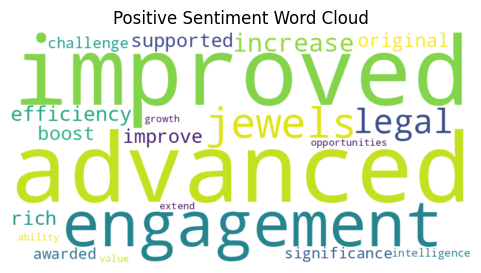

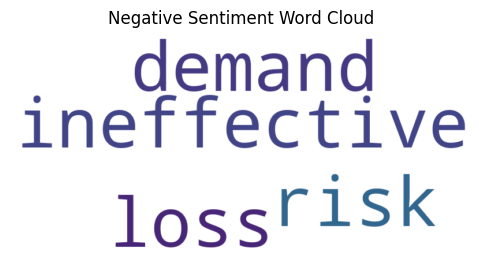

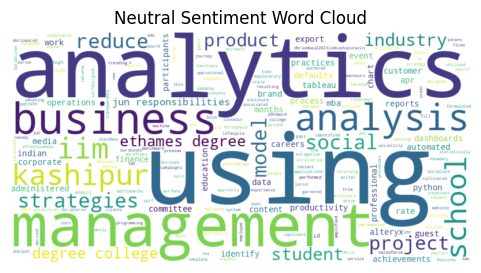

In [ ]:
# Perform sentiment analysis using NLTK
sentiment_nltk = analyze_sentiment_nltk(processed_resume_text)

# Identify tokens for each sentiment category
positive_tokens = identify_tokens_by_sentiment(processed_resume_text, 'POSITIVE')
negative_tokens = identify_tokens_by_sentiment(processed_resume_text, 'NEGATIVE')
neutral_tokens = identify_tokens_by_sentiment(processed_resume_text, 'NEUTRAL')

# Store tokens in a dictionary
sentiment_tokens_dict = {
    'POSITIVE': positive_tokens,
    'NEGATIVE': negative_tokens,
    'NEUTRAL': neutral_tokens
}

# Visualize sentiments using Plotly Pie Chart
sentiments_count = {sentiment_nltk: len(sentiment_tokens_dict[sentiment_nltk]) for sentiment_nltk in sentiment_tokens_dict}
visualize_sentiments_pie(sentiments_count)

# Generate and display word clouds with titles
generate_word_cloud_with_title(positive_tokens, 'Positive Sentiment Word Cloud')
generate_word_cloud_with_title(negative_tokens, 'Negative Sentiment Word Cloud')
generate_word_cloud_with_title(neutral_tokens, 'Neutral Sentiment Word Cloud')

<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Generating ATS Score</b>
            </span>   
        </font>    
</h4>

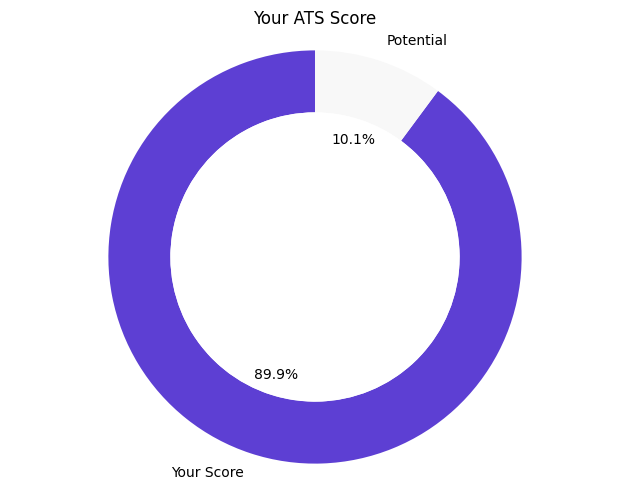

General ATS Score: 89.86%


In [ ]:
ats_score = calculate_general_ats_score(resume_text)

# Visualize the similarity using a donut chart
fig, ax = plt.subplots()
ax.pie([ats_score, 100 - ats_score], labels=['Your Score', 'Potential'], autopct='%1.1f%%', startangle=90, colors=['#5D3FD3','#F8F8F8'], wedgeprops=dict(width=0.3))

# Draw center circle to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.tight_layout()

# Show the donut chart
plt.title('Your ATS Score')
plt.show()

print(f"General ATS Score: {ats_score:.2f}%")


<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Finding similarity between the resume and uploaded job description</b>
            </span>   
        </font>    
</h4>

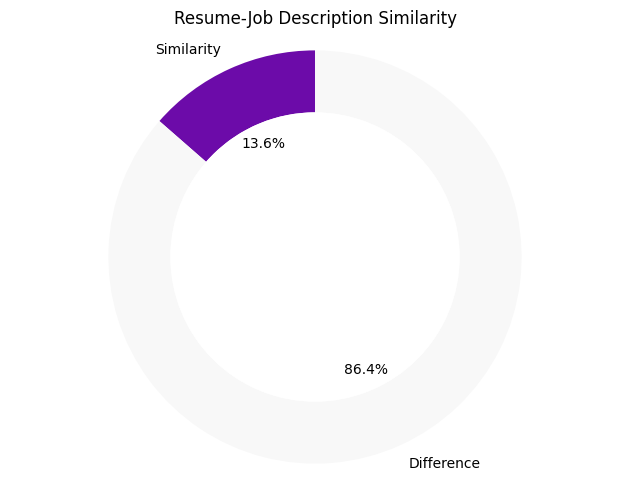

Similarity Percentage: 13.57%


In [ ]:
# Calculate similarity
similarity_percentage = calculate_similarity(processed_resume_text, processed_job_description)

# Visualize the similarity using a donut chart
fig, ax = plt.subplots()
ax.pie([similarity_percentage, 1 - similarity_percentage], labels=['Similarity', 'Difference'], autopct='%1.1f%%', startangle=90, colors=['#6C0BA9','#F8F8F8'], wedgeprops=dict(width=0.3))

# Draw center circle to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.tight_layout()

# Show the donut chart
plt.title('Resume-Job Description Similarity')
plt.show()

# Output the similarity percentage
print(f"Similarity Percentage: {similarity_percentage * 100:.2f}%")

<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Find job roles matching the resume</b>
            </span>   
        </font>    
</h4>

In [ ]:
matching_roles = find_matching_job_roles(resume_text, job_roles, num_roles=5)

# Print the matching job roles
print("Matching Job Roles:")
for role in matching_roles:
    print("- " + role)


Matching Job Roles:
- Health and Safety Manager
- Learning and Development Specialist
- Health and Safety Officer
- Occupational Health and Safety Specialist
- Business Analyst


<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Utilizing NER to highlight the Skills found in the Resume</b>
            </span>   
        </font>    
</h4>

In [ ]:
resume_tags = pos_tags(resume_text)

grammar = "NP: {<DT>?<JJ>*<NN>}"
chunk_parser = nltk.RegexpParser(grammar)
resume_tags = [chunk_parser.parse(x) for x in resume_tags]

resume_tags = [nltk.chunk.tree2conlltags(x) for x in resume_tags]

X_resume_tags = [sent2features(s) for s in resume_tags]

y_resume_tags = [sent2labels(s) for s in resume_tags]

for example in resume_tags[:5]:
    print(example)

for features, labels in zip(X_resume_tags[:5], y_resume_tags[:5]):
    print("Features:", features)
    print("Labels:", labels)

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
try:
    crf.fit(X_resume_tags, y_resume_tags)
except AttributeError:
    pass

for s, x_features, labels in zip(resume_tags, X_resume_tags, y_resume_tags):
    print(f"Sentence: {s}")
    print(f"Features: {x_features}")
    print(f"Labels: {labels}")


[('Email', 'NNP', 'O'), ('id', 'NN', 'B-NP'), (':', ':', 'O'), ('dhruv.mbaa22025', 'NN', 'B-NP'), ('@', 'NNP', 'O'), ('iimkashipur.ac.in', 'NN', 'B-NP'), ('|', 'NNP', 'O'), ('Contact', 'NNP', 'O'), ('No', 'NNP', 'O'), ('.', '.', 'O')]
[(':', ':', 'O'), ('+91-8008600482', 'NN', 'B-NP'), ('Dhruv', 'NNP', 'O'), ('Chowdary', 'NNP', 'O'), ('|', 'NNP', 'O'), ('MBA', 'NNP', 'O'), ('(', '(', 'O'), ('Analytics', 'NNPS', 'O'), (')', ')', 'O'), ('2022-24', 'CD', 'O'), ('|', 'JJ', 'O'), ('Male', 'NNP', 'O'), (',', ',', 'O'), ('22', 'CD', 'O'), ('LinkedIn', 'NNP', 'O'), ('|', 'NNP', 'O'), ('Website', 'NNP', 'O'), ('EDUCATION', 'NNP', 'O'), ('MBA', 'NNP', 'O'), ('(', '(', 'O'), ('Analytics', 'NNPS', 'O'), (')', ')', 'O'), ('Indian', 'NNP', 'O'), ('Institute', 'NNP', 'O'), ('of', 'IN', 'O'), ('Management', 'NNP', 'O'), ('Kashipur', 'NNP', 'O'), ('IIM', 'NNP', 'O'), ('8.03/10', 'CD', 'O'), ('2024', 'CD', 'O'), ('BCom', 'NNP', 'O'), ('Computers', 'NNPS', 'O'), ('EThames', 'NNP', 'O'), ('Degree', 'NNP',

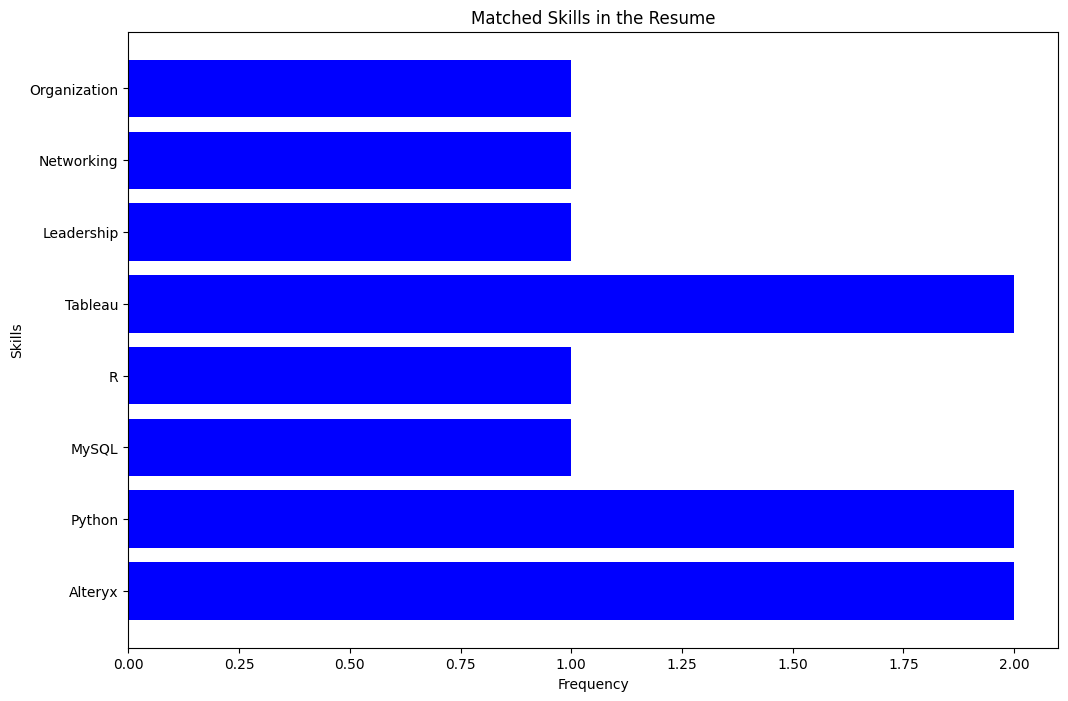

In [ ]:
# Extract skills from sentences
all_skills = [word.lower() for sent in resume_tags for word, _, _ in sent]

# Count the occurrences of each skill in the sentences
skill_counts = {skill: all_skills.count(skill.lower()) for skill in defined_skills if skill.lower() in all_skills}

# Extract the skills and counts for plotting
skills_for_plotting = list(skill_counts.keys())
counts_for_plotting = list(skill_counts.values())

# Plotting the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(skills_for_plotting, counts_for_plotting, color='blue')
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Matched Skills in the Resume')
plt.show()



<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Building Technical Question Generator</b>
            </span>   
        </font>    
</h4>

In [ ]:
# Display initial set of questions
displayed_questions = []
initial_matching_questions = find_matching_questions(processed_resume_text, technical_questions, displayed_questions, num_questions=5)
question_output = widgets.Output()
with question_output:
    display(widgets.HTML("<strong>Matching Questions:</strong>"))
    for i, question in enumerate(initial_matching_questions, 1):
        display(f"{i}. {question}")

# Button for generating new questions
generate_button = widgets.Button(description="Generate New")

def on_button_click(b):
    # Generate new set of questions
    new_matching_questions = find_matching_questions(processed_resume_text, technical_questions, displayed_questions, num_questions=5)
    question_output.clear_output()
    with question_output:
        display(widgets.HTML("<strong>Matching Questions:</strong>"))
        for i, question in enumerate(new_matching_questions, 1):
            display(f"{i}. {question}")

generate_button.on_click(on_button_click)

# Display the button and the initial set of questions
display(generate_button)
display(question_output)


Button(description='Generate New', style=ButtonStyle())

Output()

<a id="lib"></a>
<h4 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            <b>Building General Question Generator</b>
            </span>   
        </font>    
</h4>

In [ ]:
# Display initial set of questions
displayed_hr_questions = random.sample(hr_questions, min(5, len(hr_questions)))
hr_question_output = widgets.Output()
with hr_question_output:
    display(widgets.HTML("<strong>HR Questions:</strong>"))
    for i, question in enumerate(displayed_hr_questions, 1):
        display(f"{i}. {question}")

# Button for generating new HR questions
generate_hr_button = widgets.Button(description="Generate New")

def generate_new_hr_questions(b):
    # Generate new set of HR questions without repeating the previous ones
    new_hr_questions = random.sample(hr_questions, min(5, len(hr_questions)))
    hr_question_output.clear_output()
    with hr_question_output:
        display(widgets.HTML("<strong>HR Questions:</strong>"))
        for i, question in enumerate(new_hr_questions, 1):
            display(f"{i}. {question}")

generate_hr_button.on_click(generate_new_hr_questions)

# Display the button and the initial set of HR questions
display(generate_hr_button)
display(hr_question_output)


Button(description='Generate New', style=ButtonStyle())

Output()